In [1]:
# autoreload your package
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

from prob_jsonformer import Jsonformer

print("Loading model and tokenizer...")
model_name = "databricks/dolly-v2-3b"
model_name = "NousResearch/Meta-Llama-3-8B-Instruct".lower()
# model_name = "failspy/Llama-3-8B-Instruct-abliterated"
# model_name = "cognitivecomputations/Llama-3-8B-Instruct-abliterated-v2"
# model_name = "nvidia/Llama3-ChatQA-1.5-8B" # 4b
# model_name = "CohereForAI/c4ai-command-r-v01-4bit" # 35b/4 = 8.75b
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_cache=True,
    torch_dtype=torch.float16,
    attn_implementation="eager",
).to("cuda:0")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, use_cache=True)
tokenizer.padding_side = "left"
print("Loaded model and tokenizer")

/media/wassname/SGIronWolf/projects5/2024/prob_jsonformer/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading model and tokenizer...


/media/wassname/SGIronWolf/projects5/2024/prob_jsonformer/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded model and tokenizer


In [3]:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.bos_token_id

## Prob dist

- Can LLM's sample from a distribution? http://people.csail.mit.edu/renda/llm-sampling-paper
- Can they forecast events https://arxiv.org/abs/2402.07862

In [4]:
from prob_jsonformer.prob_choice_tree import prob_choice_tree
import pandas as pd
import torch.nn.functional as F
from tqdm.auto import tqdm

In [171]:
def method0(choices, n=400):
    """
    just generate many times
    """

    toks = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    data = []
    i = 0
    while i<n*10 and len(data) < n:
        i += 1
        o = model.generate(
            toks,
            do_sample=True,
            max_new_tokens=2,
            temperature=1,
            pad_token_id=tokenizer.pad_token_id
        )
        o = tokenizer.decode(o[0, -2:], skip_special_tokens=True)
        try:
            o = int(float(o))
        except ValueError:
            print(f"failed `float({o})`")
            continue
        if str(o) in choices:
            data.append(o)
        else:
            print(f"Generated `{o}` not in choices {choices}")
    d = pd.Series(data).value_counts(normalize=True).to_dict()

    df = pd.DataFrame([d]).T
    df.index = df.index.astype(int)
    df = df.sort_index()
    return df

def method1(choices):
    """
    Here we try each completion to get the hindsight probability of each choice

    from https://github.com/1rgs/jsonformer/pull/19
    """
    data = {}
    for choice in choices:
        n_option_tokens = tokenizer.encode(f'"{choice}', add_special_tokens=False, return_tensors="pt").shape[1]
        toks = tokenizer.encode(prompt + f"{choice}", return_tensors="pt").to(model.device)
        option_tokens = toks[0, -n_option_tokens:]
        o = model.forward(
            toks,
        )
        logits = o.logits[0, -n_option_tokens-1:]

        probabilities = torch.softmax(logits, dim=1)
        option_token_probabilities = probabilities[:-1][torch.arange(probabilities.shape[0]-1), option_tokens]
        option_probability = torch.prod(option_token_probabilities)
        data[choice] = option_probability.item()

    df = pd.DataFrame([data]).T
    df.index = df.index.astype(int)
    df.iloc[:, 0] = df.iloc[:, 0] / df.iloc[:, 0].sum()
    df = df.sort_index()
    return df


def method2(choices):
    """
    Useing logit constraints

    https://github.com/1rgs/jsonformer/pull/41
    """
    # TODO

def method3(choices):
    """using my prob choice tree."""
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(
        model.device
    )[0]
    choice_tokens = tokenizer(choices).input_ids
    choice_tokens = [torch.tensor(c) for c in choice_tokens]
    r = prob_choice_tree(model, tokenizer, input_ids, choice_tokens)

    df = pd.DataFrame(r).set_index('choice')
    df['prob'] = df['prob'].astype(float)
    df.index = df.index.astype(int)
    df.iloc[:, 0] = df.iloc[:, 0] / df.iloc[:, 0].sum()
    df = df.sort_index()
    return df



prompt = """Q: Please sample a number from the distribution [0, 20]: 
A: """

choices = [str(i) for i in range(21)]

ideal_dist = pd.Series({str(i): 1/21 for i in range(21)})
ideal_dist.index = ideal_dist.index.astype(int)
# ideal_dist

0    1.0
dtype: float64

In [139]:
t0 = pd.Timestamp.now()
r0 = method0(choices, n=900)
t0 = pd.Timestamp.now() - t0
r0

,0
4,0.073333
5,0.100000
7,0.100000
8,0.080000
10,0.046667
11,0.046667
12,0.125556
13,0.034444
14,0.367778
15,0.025556


In [163]:
t1 = pd.Timestamp.now()
r1 = method1(choices)
t1 = pd.Timestamp.now() - t1


In [164]:
t3 = pd.Timestamp.now()
r3 = method3(choices)
t3 = pd.Timestamp.now() - t3

,method0: sampling,method1: hindsight,method3: generation tree,ideal
0,0.000000,0.000642,0.0365,0.047619
1,0.000000,0.002812,0.0667,0.047619
2,0.000000,0.001010,0.0710,0.047619
3,0.000000,0.009076,0.0653,0.047619
4,0.073333,0.028844,0.0786,0.047619
5,0.100000,0.043982,0.0999,0.047619
6,0.000000,0.013840,0.0662,0.047619
7,0.100000,0.063993,0.0858,0.047619
8,0.080000,0.059184,0.0682,0.047619
9,0.000000,0.012213,0.0745,0.047619


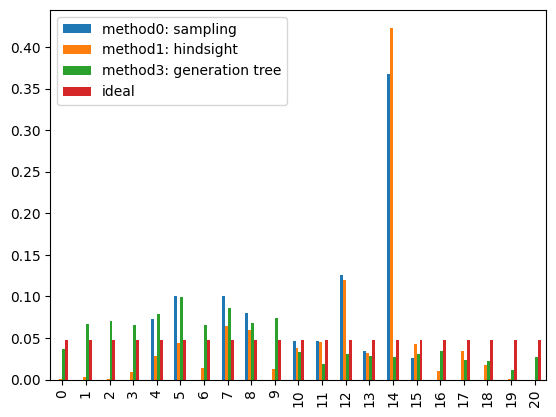

In [172]:
df = pd.concat([r0, r1, r3, ideal_dist], axis=1)
df.columns = ['method0: sampling', 'method1: hindsight', 'method3: generation tree', 'ideal']


df = df.sort_index().fillna(0)
df.plot.bar()
df

In [173]:
# df.sum()

In [174]:
df_score = df / df['ideal'].values[:, None] - 1
ratios = df_score.iloc[:21, :3]
print('MAE coverage (smaller is better')
ratios.abs().mean()

MAE coverage (smaller is better


method0: sampling           1.121905
method1: hindsight          0.952232
method3: generation tree    0.494957
dtype: float64

In [175]:
data = []
times = dict(zip(df.columns, [t0, t1, t3]))
for k in df.columns[:3]:
    input = torch.tensor(df[k].values)[None, :]
    print(input, k)
    target = torch.tensor(df['ideal'].values)[None, :]
    # https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss
    s = F.kl_div(input, target , reduction='batchmean', log_target=False).item()
    t = times[k].total_seconds()
    data.append({'method': k, 'KL_div_loss': s, 'time': t})
dfr = pd.DataFrame(data).set_index('method')
# color values with cmap
dfs = dfr.style.background_gradient(cmap='YlOrRd')
dfs.set_caption('KL_div_loss and time for each method (lower is better)')
dfs

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0733, 0.1000, 0.0000, 0.1000, 0.0800,
         0.0000, 0.0467, 0.0467, 0.1256, 0.0344, 0.3678, 0.0256, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]], dtype=torch.float64) method0: sampling
tensor([[6.4225e-04, 2.8117e-03, 1.0104e-03, 9.0762e-03, 2.8844e-02, 4.3982e-02,
         1.3840e-02, 6.3993e-02, 5.9184e-02, 1.2213e-02, 3.7620e-02, 4.5378e-02,
         1.1956e-01, 3.1679e-02, 4.2386e-01, 4.2629e-02, 1.0285e-02, 3.4793e-02,
         1.7495e-02, 1.1011e-03, 9.9832e-06]], dtype=torch.float64) method1: hindsight
tensor([[0.0365, 0.0667, 0.0710, 0.0653, 0.0786, 0.0999, 0.0662, 0.0858, 0.0682,
         0.0745, 0.0327, 0.0187, 0.0307, 0.0279, 0.0274, 0.0312, 0.0344, 0.0235,
         0.0225, 0.0109, 0.0277]], dtype=torch.float64) method3: generation tree


,KL_div_loss,time
method,,
method0: sampling,-3.092141,48.504429
method1: hindsight,-3.092141,0.683987
method3: generation tree,-3.092156,0.075112


In [176]:
print(dfr.to_markdown())

| method                   |   KL_div_loss |      time |
|:-------------------------|--------------:|----------:|
| method0: sampling        |      -3.09214 | 48.5044   |
| method1: hindsight       |      -3.09214 |  0.683987 |
| method3: generation tree |      -3.09216 |  0.075112 |


## Scratch, collapse probs

In [14]:
# def collapse_probs(json_schema, generated_data, keys = []):

#     # get current row
#     schema = json_schema
#     data = generated_data
#     for key in keys[:-1]:
#         print(schema)
#         schema = schema[key]
#         data = data[key]

#     schema_type = schema["type"]

#     if schema_type == "p_enum":
#         k = keys[-1]
#         data[k] = data[k][0]['choice']
#     elif schema_type == "object":
#         k = "properties"
#         for key in schema["properties"]:
#             data["properties"] = collapse_probs(json_schema, generated_data, keys + [key])
    
#     return generated_data


# list(collapse_probs(json_schema, generated_data))